# Baseline - Train and Save Best Case

## Set Up

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import json
from scipy.sparse import load_npz

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import sys
# Add the workspace root to sys.path so 'scripts' can be imported
sys.path.append(str(Path.cwd().parents[2]))

from scripts.utils import tune_thresholds


In [3]:
PATH = Path.cwd().parents[2]
DATA_PATH = os.path.join(PATH, 'data/external/crpwarner/merged')
SAVE_PATH = os.path.join(PATH, 'models/1_groundtruth_with_large')

In [4]:
df = pd.read_csv(os.path.join(DATA_PATH, 'mint.csv')).set_index('address')
df.head()

,TP?
address,
0x93023F1D3525E273F291B6f76d2F5027A39BF302,1
0x2753dcE37A7eDB052a77832039bcc9aA49Ad8b25,0
0x94b7D24552933F50A5A5705C446528806dCeA381,0
0xE0b9d4146AaD6936cBfcBE4dAE47e34aAb96b093,0
0x10f6f2b97F3aB29583D9D38BaBF2994dF7220C21,1


In [5]:
y = np.array([df['TP?']]).T

In [6]:
sol_files = []

for file in list(Path(os.path.join(DATA_PATH, 'sol')).glob('*.sol')):
    if file.stem in df.index:
        sol_files.append(file)

hex_files = []

for file in list(Path(os.path.join(DATA_PATH, 'hex')).glob('*.hex')):
    if file.stem in df.index:
        hex_files.append(file)

### MPL

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2025-07-18 23:14:09.423242: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
def Model(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(512, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.4),

        Dense(256, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.3),

        Dense(128, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.2),

        Dense(output_dim, activation='sigmoid')  # sigmoid for multi-label
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-6),
        metrics=['accuracy']
    )
    return model

## Best Binary Model by Class

### Mint

#### TF-IDF (Source Code)

In [9]:
from scripts.feature_extractions.tf_idf import get_tf_idf_vector

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
X, cols  = get_tf_idf_vector(sol_files)
# X.head()
X

100%|██████████| 161/161 [00:00<00:00, 8494.66it/s]


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 56379 stored elements and shape (161, 8221)>

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#### Train Model

In [13]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

#### Evaluate Model

In [14]:
y_pred = model.predict(X_test)

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.91      0.61        11
           1       0.91      0.45      0.61        22

    accuracy                           0.61        33
   macro avg       0.68      0.68      0.61        33
weighted avg       0.76      0.61      0.61        33



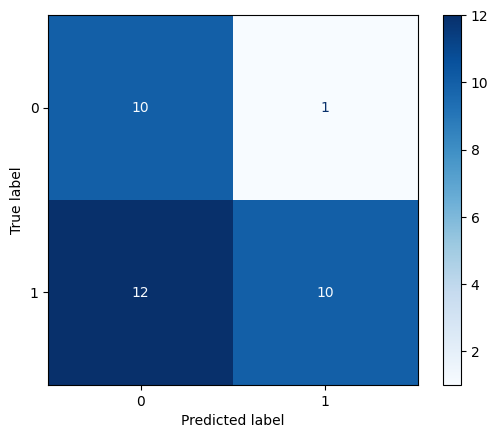

In [16]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

In [17]:
score = f1_score(y_test, y_pred, average='macro')
name = "mint-tf-idf"
with open(os.path.join(SAVE_PATH, fr"{name}-f1-{score:2f}.pkl"), "wb") as fout:
    pickle.dump(model, fout)
print(f"Saved {name}-model.pkl")

Saved mint-tf-idf-model.pkl


In [18]:
with open(os.path.join(SAVE_PATH, f"{name}-feature.json"), "w") as fout:
    json.dump(list(cols.keys()), fout, indent=2)